In [125]:
#load libraries
import numpy as np
import math
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean
from scipy.stats import norm, lognorm
import seaborn as sns
sns.set()
sns.set_style('white')
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance, Voronoi, voronoi_plot_2d, ConvexHull, Delaunay
from collections import defaultdict
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
import sys
from itertools import combinations 
import time
from shapely.geometry import Polygon

In [3]:
#import data
coords_and_grain_IDs=np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(3,4,8))
coords=coords_and_grain_IDs[:,0:2]

In [8]:
#get area of each voronoi region
def voronoi_volumes(points):
    #create voronoi diagram
    v = Voronoi(points)
    #create zeros of len points
    vol = np.zeros(v.npoints)
    #create vol index and get index of voronoi region for input point 
    #need to see if point_region can be recreated from above
    for i, reg_num in enumerate(v.point_region):
        #get indices of each region
        indices = v.regions[reg_num]
        #-1 means vertex outside diagram
        if -1 in indices: # some regions can be opened
            #maybe instead of inf, ignore?
            #vol[i] = np.inf
            vol[i] = 0
        else:
            #can compute area, use convex hull
            vol[i] = ConvexHull(v.vertices[indices]).volume
    #can use grain IDs, since areas match input point
    return vol

In [101]:
#get area of each voronoi region
def voronoi_volumes_finite(points):
    v = Voronoi(points)
    #create zeros of len points
    vol = np.zeros(v.npoints)
    #create vol index and get index of voronoi region for input point 
    for i, reg_num in enumerate(v.point_region):
        #get indices of each region
        indices = v.regions[reg_num]
        #-1 means vertex outside diagram
        if -1 in indices: # some regions can be opened
            #ignore infinite regions
            vol[i] = 0
            
        else: #can compute area, use convex hull
            vert=v.vertices[indices]
            edge=0
            small=np.where(vert<0)
            large=np.where(vert>110)
            if ((len(small[0])) > 0 or (len(large[0])) > 0):
                edge=1
                vert[small]=0
                vert[large]=110
            
            if edge==1: #double size of edge grains
                vol[i] = (2*ConvexHull(vert).volume)
            else: #all vertices are inside 
                vol[i] = ConvexHull(vert).volume
                
    #can use grain IDs, since areas match input point
    return vol

In [133]:
#get area of each voronoi region
def voronoi_volumes_finite_timed(points):
    start = time.time()
    v = Voronoi(points)
    end = time.time()
    print(end - start)
    print('Create Voronoi')
    
    #create zeros of len points
    vol = np.zeros(v.npoints)
    #create vol index and get index of voronoi region for input point 
    
    start = time.time()
    num_loops=0
    for i, reg_num in enumerate(v.point_region):
        num_loops+=1
        #get indices of each region
        indices = v.regions[reg_num]
        #-1 means vertex outside diagram
        if -1 in indices: # some regions can be opened
            #ignore infinite regions
            vol[i] = 0
            
        else: #can compute area, use convex hull
            vert=v.vertices[indices]
            edge=0
            small=np.where(vert<0)
            large=np.where(vert>110)
            if ((len(small[0])) > 0 or (len(large[0])) > 0):
                edge=1
                vert[small]=0
                vert[large]=110
            
            if edge==1: #double size of edge grains
                vol[i] = (2*ConvexHull(vert).volume)
            else: #all vertices are inside 
                vol[i] = ConvexHull(vert).volume
    end = time.time()
    print(end - start)
    print('For Loop')
                
    print('Numloops: '+str(num_loops))
    #can use grain IDs, since areas match input point
    return vol

In [134]:
random_coords=coords[np.random.choice(coords.shape[0], 50, replace=False), :]
print(len(random_coords))

50


In [135]:
start = time.time()
voronoi_volumes_finite_timed(random_coords)
end = time.time()
print(end - start)
print('Elapsed Time')

0.00997304916381836
Create Voronoi
0.3281219005584717
For Loop
Numloops: 50
0.3390941619873047
Elapsed Time


In [136]:
print('Sec/loop: '+str(0.34/50))

Sec/loop: 0.0068000000000000005


In [ ]:
#given random_vor take an average of six min/iteration

In [138]:
hours=12
minutes=hours*60
minutes_per_loop=6
num_loops=minutes/minutes_per_loop
print(num_loops)

120.0


In [51]:
def random_vor(sample,binsize=249,hist=True,mean_var=False):
    #choose random points
    random_coords_and_grains=coords_and_grains[np.random.choice(coords_and_grains.shape[0], sample, replace=False), :]
    random_coords=random_coords_and_grains[:,0:2]
    random_grain_IDs=random_coords_and_grains[:,2]
    
    #get areas
    vol=voronoi_volumes(random_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    #this is where proper indexing is critical
    grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

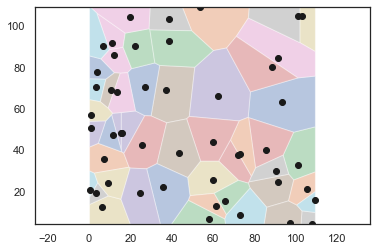

In [50]:
# # make up data points
# np.random.seed(1234)
# points = np.random.rand(15, 2)

# compute Voronoi tesselation
vor = Voronoi(random_coords)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

min_x = vor.min_bound[0] - 0.1
max_x = vor.max_bound[0] + 0.1
min_y = vor.min_bound[1] - 0.1
max_y = vor.max_bound[1] + 0.1

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)



box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

# colorize
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]

    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(random_coords[:, 0], random_coords[:, 1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('voro.png')
plt.show()

In [43]:
voronoi_volumes_finite(random_coords)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


78


(0, 250)

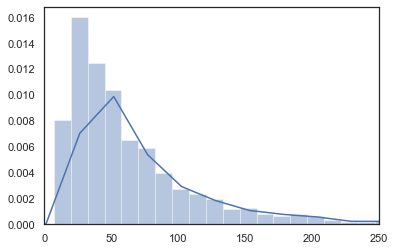

In [95]:
#actual distribution
uniquegrains=np.unique(coords_and_grain_IDs[:,2],return_counts=True)
ID, count = uniquegrains
print(mean(count))
sns.distplot(count, hist=True, bins=250, kde=True)
plt.xlim(0,250)

In [6]:
def q(count):
    params = lognorm.fit(count)
    xvals = np.linspace(0, 250, num=250)
    pdf = lambda x: lognorm.pdf(xvals, *params)
    q = pdf(xvals)
    q[q==0]=[0.000001]
    return q

In [7]:
def actual():
    sns.distplot(count, hist=True, bins=250, kde=True)
    plt.xlim(0,250)

In [ ]:
regions, vertices = voronoi_finite_polygons_2d(vor)

In [9]:
#find total area of the voronoi regions
def vor_areas(sample):
    random_coords_and_grain_IDs=coords_and_grain_IDs[np.random.choice(coords_and_grain_IDs.shape[0], sample, replace=False), :]
    random_coords=random_coords_and_grain_IDs[:,0:2]
    vol=voronoi_volumes_finite(random_coords)
    return sum(vol)

In [10]:
#choose random points
random_coords_and_grain_IDs=coords_and_grain_IDs[np.random.choice(coords_and_grain_IDs.shape[0], 50, replace=False), :]
random_coords=random_coords_and_grain_IDs[:,0:2]
random_grain_IDs=random_coords_and_grain_IDs[:,2]

In [11]:
def adj_dict(coords):
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)

0:6,39,45,48,19
1:32,36,7,43,47,18,24,26
2:5,41,10,13,49,18,27
3:33,5,8,42,27,31
4:11,46,14,20,23,30
5:2,3,41,42,25,27,29
6:0,39,45,46,16,20,22
7:32,1,36,22
8:33,3,35,40,42,21
9:34,37,38,11,48,28
10:2,43,13,18,24,26,31
11:34,4,38,9,23,30
12:40,44,17,21,25,28,29
13:27,2,10,31
14:48,4,46,30
15:32,33,35,20,23,24
16:36,6,22,39
17:25,12,49
18:1,2,10,47,49,26
19:48,0,45
20:32,4,6,46,15,22,23
21:8,40,42,12,29
22:32,36,6,7,16,20
23:35,4,38,40,11,44,15,20
24:32,1,33,10,43,15,31
25:5,41,12,17,49,29
26:1,10,43,47,18
27:2,3,5,13,31
28:37,38,9,12,44
29:5,42,12,21,25
30:34,4,11,14,48
31:33,3,10,13,24,27
32:1,7,15,20,22,24
33:3,35,8,15,24,31
34:48,9,11,30
35:33,40,8,15,23
36:1,7,39,16,22
37:9,28,38
38:37,9,11,44,23,28
39:16,0,36,6
40:35,8,44,12,21,23
41:49,2,5,25
42:3,5,8,21,29
43:24,1,26,10
44:38,40,12,23,28
45:0,6,46,48,19
46:4,6,45,14,48,20
47:1,18,26
48:0,34,9,45,46,14,19,30
49:2,41,17,18,25
{1, 10, 43, 47, 18}
1
10
43
47
18


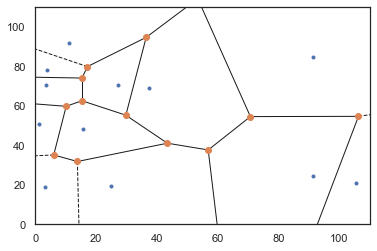

In [12]:
tri=Delaunay(random_coords)
neigh=defaultdict(set)
for p in tri.simplices:
    for i,j in itertools.combinations(p,2):
        neigh[i].add(j)
        neigh[j].add(i)

for key in sorted(neigh.keys()):
    print("%d:%s" % (key,','.join([str(i) for i in neigh[key]])))

print(neigh[26])
for i in neigh[26]:
    print(i)

adj_random_coords=random_coords[[0,41,26,19,5,34,4,37,44,15,16,20],:]
vor=Voronoi(adj_random_coords)
voronoi_plot_2d(vor)
# for i,p in enumerate():
#     plt.text(p[0], p[1], '#%d' % i, ha='center')
plt.xlim(0,110)
plt.ylim(0,110)
plt.show()

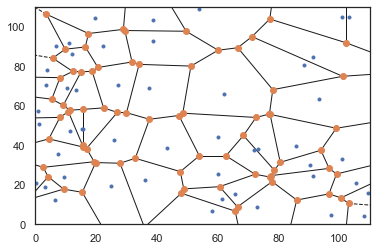

In [13]:
#plot figure, note shapes outside the bounds
vor = Voronoi(random_coords)
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.xlim(0,110)
plt.ylim(0,110)
plt.show()

In [14]:
#choose grid points
grid_coords_and_grain_IDs=coords_and_grain_IDs[::2000]
grid_coords=grid_coords_and_grain_IDs[:,0:2]
grid_grain_IDs=grid_coords_and_grain_IDs[:,2]

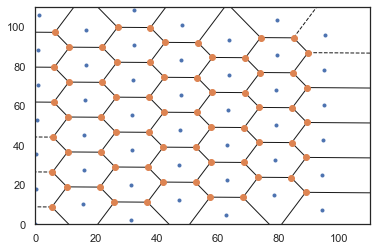

In [41]:
new_vor = Voronoi(grid_coords)
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(new_vor)
plt.xlim(0,110)
plt.ylim(0,110)
plt.show()

(array([39.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00000000e+00, 2.19248757e+10, 4.38497515e+10, 6.57746272e+10,
        8.76995030e+10, 1.09624379e+11, 1.31549254e+11, 1.53474130e+11,
        1.75399006e+11, 1.97323882e+11, 2.19248757e+11]),
 <a list of 10 Patch objects>)

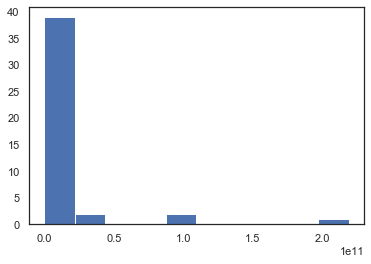

In [112]:
#points at infinity
plt.hist(voronoi_volumes(grid_coords))

(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 21.,  5.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
        390, 420, 450, 480, 510, 540, 570]),
 <a list of 19 Patch objects>)

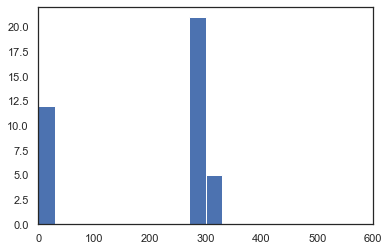

In [117]:
plt.xlim(0,600)
plt.hist(voronoi_volumes(grid_coords),bins=range(0,600,30))

(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 21.,  1.,  0.,  0.,
         0.,  0.,  3.,  1.,  2.,  1.]),
 array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
        390, 420, 450, 480, 510, 540, 570]),
 <a list of 19 Patch objects>)

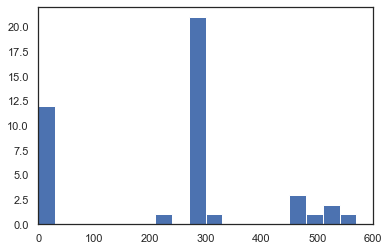

In [119]:
plt.xlim(0,600)
plt.hist(voronoi_volumes_finite(grid_coords),bins=range(0,600,30))
#note edge cases doubled

In [17]:
#turn area into percent of total area
norm_vol=(vol)/sum(vol)
#multiply by total number of pixels to find how many pixels in each area
scale_vol=norm_vol*87017
#round to nearest whole number
round_vol=np.round(scale_vol,decimals=0)
#create array, col1 is ID, col2 is area
grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
#get unique IDs and their count
unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
#create array to hold unique IDs and their sizes added together
unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)

In [18]:
#construct IDs and count
for row in unique_grain_IDs_and_total_areas:
    grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
    total=np.sum(grain[:,1])
    row[1]=total
print(unique_grain_IDs_and_total_areas)

[[3.6000e+01 3.8733e+04]
 [4.1000e+01 0.0000e+00]
 [5.2000e+01 0.0000e+00]
 [1.1100e+02 1.9900e+03]
 [1.1800e+02 6.4300e+02]
 [1.2000e+02 0.0000e+00]
 [1.3300e+02 0.0000e+00]
 [1.4600e+02 2.6800e+02]
 [1.5300e+02 3.4500e+02]
 [1.7800e+02 1.3980e+03]
 [2.2400e+02 3.1700e+02]
 [2.3300e+02 0.0000e+00]
 [2.4400e+02 1.2500e+02]
 [2.5300e+02 6.9100e+02]
 [2.6400e+02 1.0200e+03]
 [2.7700e+02 5.6400e+02]
 [2.8800e+02 4.0400e+02]
 [3.7100e+02 6.7200e+02]
 [3.8300e+02 3.6000e+03]
 [4.2700e+02 3.7300e+02]
 [4.4000e+02 7.6700e+02]
 [4.4500e+02 4.4300e+02]
 [4.4700e+02 9.6200e+02]
 [4.9000e+02 8.6200e+02]
 [5.0200e+02 2.4900e+02]
 [5.1100e+02 8.8900e+02]
 [5.4000e+02 4.3800e+02]
 [5.6100e+02 7.1690e+03]
 [5.7700e+02 1.1460e+03]
 [5.9600e+02 0.0000e+00]
 [6.8400e+02 3.9020e+03]
 [7.3200e+02 1.9090e+03]
 [7.6600e+02 4.0800e+02]
 [7.6900e+02 9.3400e+02]
 [7.9000e+02 1.9600e+02]
 [7.9600e+02 6.6900e+02]
 [8.1300e+02 2.5650e+03]
 [9.0900e+02 1.1680e+03]
 [9.1100e+02 2.9900e+02]
 [9.3800e+02 0.0000e+00]


(0, 250)

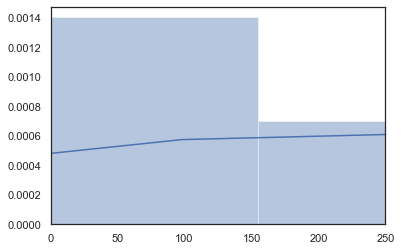

In [19]:
sns.distplot(unique_grain_IDs_and_total_areas[:,1], hist=True, bins=250, kde=True)
plt.xlim(0,250)

In [104]:
import time

In [120]:
def random_vor_count(sample):
    start = time.time()
    #choose random points
    random_coords_and_grain_IDs=coords_and_grain_IDs[np.random.choice(coords_and_grain_IDs.shape[0], sample, replace=False), :]
    random_coords=random_coords_and_grain_IDs[:,0:2]
    random_grain_IDs=random_coords_and_grain_IDs[:,2]
    end = time.time()
    print(end - start)
    
    start = time.time()
    #get areas
    vol=voronoi_volumes_finite(random_coords)   
    end = time.time()
    print(end - start)
    
    start = time.time()
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    end = time.time()
    print(end - start)
    
    start = time.time()
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    end = time.time()
    print(end - start)
    
    #return count for hist
    return unique_grain_IDs_and_total_areas[:,1]

In [123]:
# start = time.time()
# sns.distplot(random_vor_count(44000), hist=True, bins=250, kde=True)
# plt.xlim(0,250)
# end = time.time()
# print(end - start)
# #nearly 6min to generate a distribution!
# #vor_finite_volumes takes the longest!

In [22]:
def grid_vor_count(res):
    #choose random points
    grid_coords_and_grain_IDs=coords_and_grain_IDs[::res]
    grid_coords=grid_coords_and_grain_IDs[:,0:2]
    grid_grain_IDs=grid_coords_and_grain_IDs[:,2]
    
    #get areas
    vol=voronoi_volumes(grid_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((grid_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #return count for hist
    return unique_grain_IDs_and_total_areas[:,1]

(0, 250)

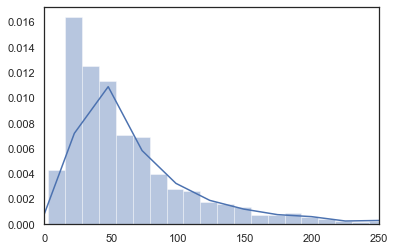

In [23]:
sns.distplot(grid_vor_count(2), hist=True, bins=250, kde=True)
plt.xlim(0,250)

In [24]:
def fine_grid_vor_count(res):
    #choose random points
    fine_grid_coords_and_grain_IDs=np.delete(coords_and_grain_IDs, np.arange(0, coords_and_grain_IDs.size, res))
    fine_grid_coords=fine_grid_coords_and_grain_IDs[:,0:2]
    fine_grid_grain_IDs=fine_grid_coords_and_grain_IDs[:,2]
    
    #get areas
    vol=voronoi_volumes(fine_grid_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((fine_grid_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #return count for hist
    return unique_grain_IDs_and_total_areas[:,1]

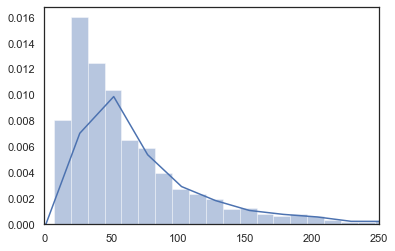

In [25]:
actual()

In [26]:
random_percent=[]
for i in range (10000,80000,10000):
    random_percent.append((i/87000)*100)
    
grid_percent=[]
for i in range(1,50,1):
    grid_percent.append(((87017/i)/87017)*100)
    
fine_grid_percent=[]
for i in range(2,100,1):
    fine_grid_percent.append(((87017-(87017/i))/87017)*100)

In [27]:
params = lognorm.fit(count)
xvals = np.linspace(0, 250, num=250)
pdf = lambda x: lognorm.pdf(xvals, *params)
t = pdf(xvals)
#remove 0 values to prevent KL error
t[t==0]=[0.000001]

In [28]:
def kl_divergence(p, q):
    return np.sum(np.where((q != 0), p * np.log2(p / q), 0))
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [30]:
random_divergence=[]
for i in range (10000,80000,10000):
    random_divergence.append(js_divergence(q(random_vor_count(i)),t))

In [1]:
# grid_divergence=[]
# for i in range(1,50,1):
#     grid_divergence.append(js_divergence(q(grid_vor_count(i)),t))

In [ ]:
fine_grid_divergence=[]
for i in range(2,100,1):
    fine_grid_divergence.append(js_divergence(q(fine_grid_vor_count(i)),t))

In [ ]:
plt.xlim(0, 100)
plt.ylim(-0.1, 1)
#plt.title('JS Divergence of Dataset and Grid Sampled Subset')
plt.title('JS Divergence from Actual')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')
#random
sns.scatterplot(random_percent, random_divergence, s=100, color="purple", marker="o", label='Random')
#grid
sns.scatterplot(grid_percent, grid_divergence, s=100, color="green", marker="o", label='Grid')
#fine grid
sns.scatterplot(fine_grid_percent, fine_grid_divergence, s=100, color="blue", marker="o", label='Fine Grid')

In [ ]:
#how is area affected by sample size?
samples=[]
areas=[]
for sample in range (100,1000,100):
    samples.append(sample)
    areas.append(vor_areas(sample))
print(samples) 
print(areas)

In [ ]:
sns.scatterplot(x=samples,y=areas)
plt.axhline(y=120**2, color='red', linestyle='-')

In [96]:
vor_areas(87017)

11945.007469067443

In [97]:
vor_areas(44000)

12094.525310549416

In [98]:
vor_areas(22000)

14499.871420687698

In [99]:
vor_areas(11000)

16794.538930976276

In [100]:
vor_areas(5500)

45847.84132816208

In [ ]:
# # generate Voronoi tessellation
# vor = Voronoi(random_coords)

# # find min/max values for normalization
# minima = min(random_grain_IDs)
# maxima = max(random_grain_IDs)

# # normalize chosen colormap
# norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
# mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)

# # plot Voronoi diagram, and fill finite regions with color mapped from speed value
# voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1)
# for r in range(len(vor.point_region)):
#     region = vor.regions[vor.point_region[r]]
#     if not -1 in region:
#         polygon = [vor.vertices[i] for i in region]
#         plt.fill(*zip(*polygon), color=mapper.to_rgba(random_grain_IDs[r]))
# plt.show()

In [ ]:
# # print(points)
# # print(coords)
# print(speed)
# print(grain_IDs)

In [ ]:
# # ordering vertices
# vertices=vor.vertices
# x_plus = np.array([1, 0]) # unit vector in i direction to measure angles from
# theta = np.zeros(len(vertices))
# for v_i in range(len(vertices)):
#     ri = vertices[v_i]
#     if ri[1]-self.r[1] >= 0: # angle from 0 to pi
#         cosine = np.dot(ri-self.r, x_plus)/np.linalg.norm(ri-self.r)
#         theta[v_i] = np.arccos(cosine)
#     else: # angle from pi to 2pi
#         cosine = np.dot(ri-self.r, x_plus)/np.linalg.norm(ri-self.r)
#         theta[v_i] = 2*np.pi - np.arccos(cosine)

# order = np.argsort(theta) # returns array of indices that give sorted order of theta
# vertices_ordered = np.zeros(vertices.shape)
# for o_i in range(len(order)):
#     vertices_ordered[o_i] = vertices[order[o_i]]

# # compute the area of cell using ordered vertices (shoelace formula)
# partial_sum = 0
# for i in range(len(vertices_ordered)-1):
#     partial_sum += vertices_ordered[i,0]*vertices_ordered[i+1,1] - vertices_ordered[i+1,0]*vertices_ordered[i,1]
#     partial_sum += vertices_ordered[-1,0]*vertices_ordered[0,1] - vertices_ordered[0,0]*vertices_ordered[-1,1]
# area = 0.5 * abs(partial_sum)